# Imports and data

In [94]:
import time
import timeit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()

from sklearn.cluster import KMeans
from sklearn import preprocessing

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor

from scipy.stats import ttest_rel

In [95]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
# Note: Data is asking prices on Auto Trader; these are not necessarily the price they sell for
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/car_data.csv')
# data = pd.read_csv('/data/car_data.csv')
data.sort_values(by='Price', inplace=True)
data.reset_index(drop=True, inplace=True)
data['Trim'] = data['Trim'].map({'ST-3':1, 'ST-2':0})
data.describe(include='all')
# data.head()

,Price,Year,Generation,Trim,Mileage,Distance,Private
count,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000
mean,11913.724409,2017.648819,7.464567,0.573228,47636.426772,175.433071,0.217323
std,5391.029049,3.085707,0.499136,0.494998,27875.479021,71.853842,0.412749
min,3030.000000,2013.000000,7.000000,0.000000,9.000000,7.000000,0.000000
25%,7487.500000,2015.000000,7.000000,0.000000,23339.000000,135.000000,0.000000
50%,10000.000000,2017.000000,7.000000,1.000000,47000.000000,174.000000,0.000000
75%,15992.500000,2020.000000,8.000000,1.000000,67664.000000,208.000000,0.000000
max,26950.000000,2024.000000,8.000000,1.000000,164530.000000,462.000000,1.000000


In [97]:
mine = pd.DataFrame({
    'Year': [2017],
    'Generation': [7],
    'Trim': [1],
    'Mileage': [38000],
    'Distance': [1],
    'Private': [1]
})

In [98]:
gen7_data = data[data['Generation'] == 7]
gen7_st2_private_data = data[(data['Private'] == 1) & (data['Generation'] == 7) & (data['Trim'] == 0)]
gen7_st2_trade_data = data[(data['Private'] == 0) & (data['Generation'] == 7) & (data['Trim'] == 0)]
gen7_st3_private_data = data[(data['Private'] == 1) & (data['Generation'] == 7) & (data['Trim'] == 1)]
gen7_st3_trade_data = data[(data['Private'] == 0) & (data['Generation'] == 7) & (data['Trim'] == 1)]

gen8_data = data[data['Generation'] == 8]
gen8_st2_private_data = data[(data['Private'] == 1) & (data['Generation'] == 8) & (data['Trim'] == 0)]
gen8_st2_trade_data = data[(data['Private'] == 0) & (data['Generation'] == 8) & (data['Trim'] == 0)]
gen8_st3_private_data = data[(data['Private'] == 1) & (data['Generation'] == 8) & (data['Trim'] == 1)]
gen8_st3_trade_data = data[(data['Private'] == 0) & (data['Generation'] == 8) & (data['Trim'] == 1)]

# Graphs

## Price vs

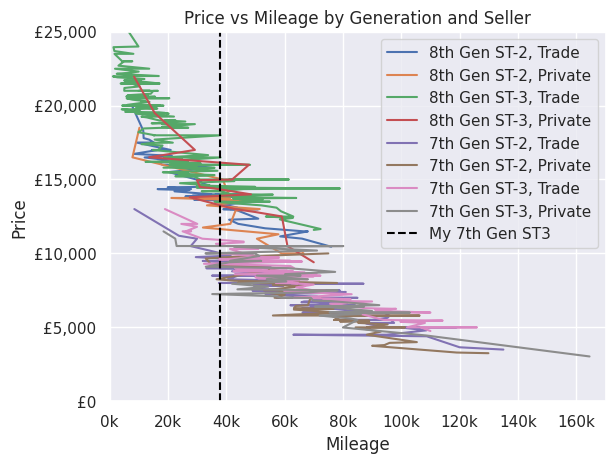

In [99]:
x_col = 'Mileage'

y_gen7_st2_private = gen7_st2_private_data['Price']
y_gen7_st2_trade = gen7_st2_trade_data['Price']
x_gen7_st2_private = gen7_st2_private_data[x_col]
x_gen7_st2_trade = gen7_st2_trade_data[x_col]

y_gen7_st3_private = gen7_st3_private_data['Price']
y_gen7_st3_trade = gen7_st3_trade_data['Price']
x_gen7_st3_private = gen7_st3_private_data[x_col]
x_gen7_st3_trade = gen7_st3_trade_data[x_col]

y_gen8_st2_private = gen8_st2_private_data['Price']
y_gen8_st2_trade = gen8_st2_trade_data['Price']
x_gen8_st2_private = gen8_st2_private_data[x_col]
x_gen8_st2_trade = gen8_st2_trade_data[x_col]

y_gen8_st3_private = gen8_st3_private_data['Price']
y_gen8_st3_trade = gen8_st3_trade_data['Price']
x_gen8_st3_private = gen8_st3_private_data[x_col]
x_gen8_st3_trade = gen8_st3_trade_data[x_col]

plt.plot(x_gen8_st2_trade, y_gen8_st2_trade, label='8th Gen ST-2, Trade')
plt.plot(x_gen8_st2_private, y_gen8_st2_private, label='8th Gen ST-2, Private')

plt.plot(x_gen8_st3_trade, y_gen8_st3_trade, label='8th Gen ST-3, Trade')
plt.plot(x_gen8_st3_private, y_gen8_st3_private, label='8th Gen ST-3, Private')

plt.plot(x_gen7_st2_trade, y_gen7_st2_trade, label='7th Gen ST-2, Trade')
plt.plot(x_gen7_st2_private, y_gen7_st2_private, label='7th Gen ST-2, Private')

plt.plot(x_gen7_st3_trade, y_gen7_st3_trade, label='7th Gen ST-3, Trade')
plt.plot(x_gen7_st3_private, y_gen7_st3_private, label='7th Gen ST-3, Private')

plt.axvline(38000, color='black', linestyle='--', label='My 7th Gen ST3')

plt.legend()
plt.title('Price vs Mileage by Generation and Seller')
ax = plt.gca()

plt.ylabel('Price')
plt.ylim(0,25000)
def currency_formatter(y, pos):
    return '£{:,.0f}'.format(y)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))

plt.xlabel('Mileage')
plt.xlim(0,170000)
def thousands_formatter(x, pos):
    return '{:.0f}k'.format(x / 1000)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))

plt.show()

## Histograms

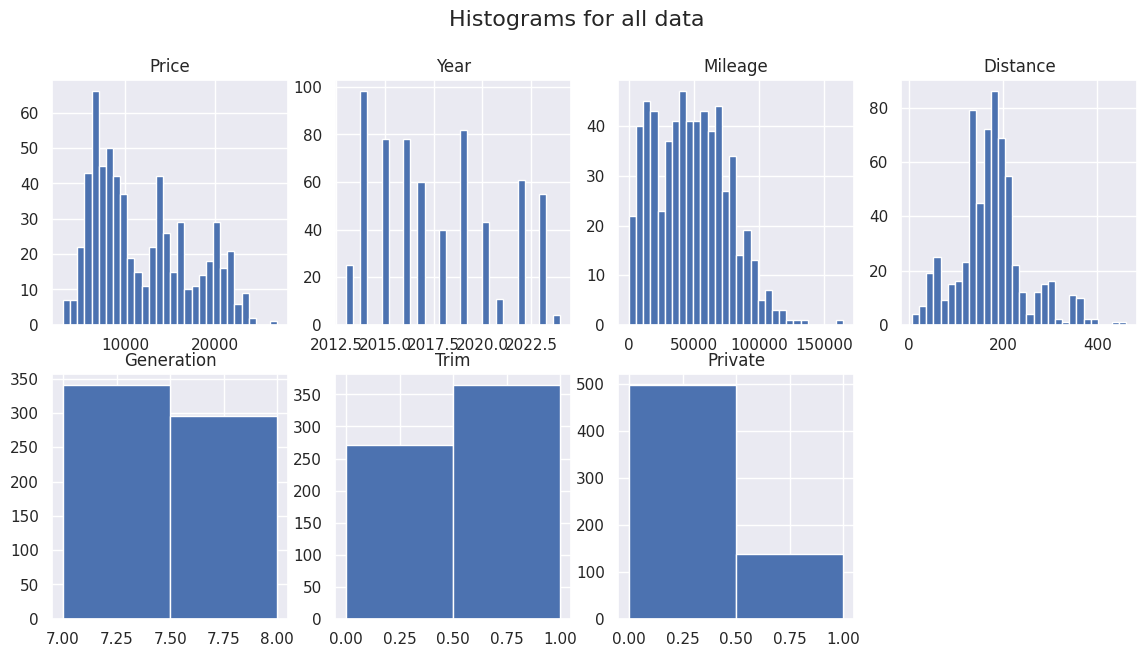

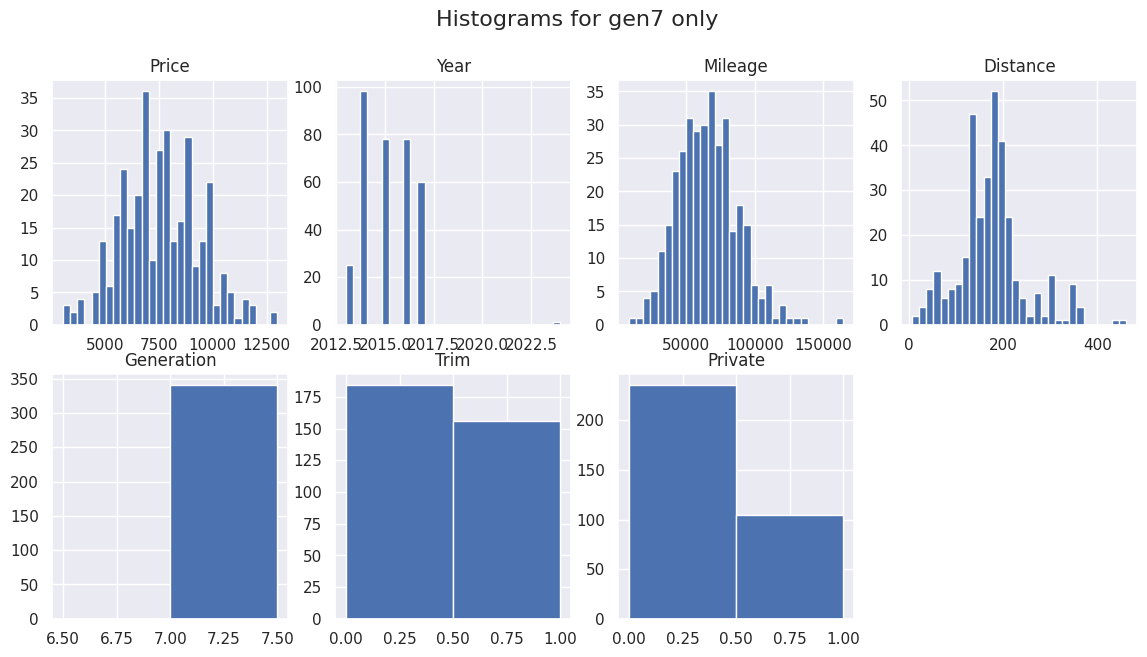

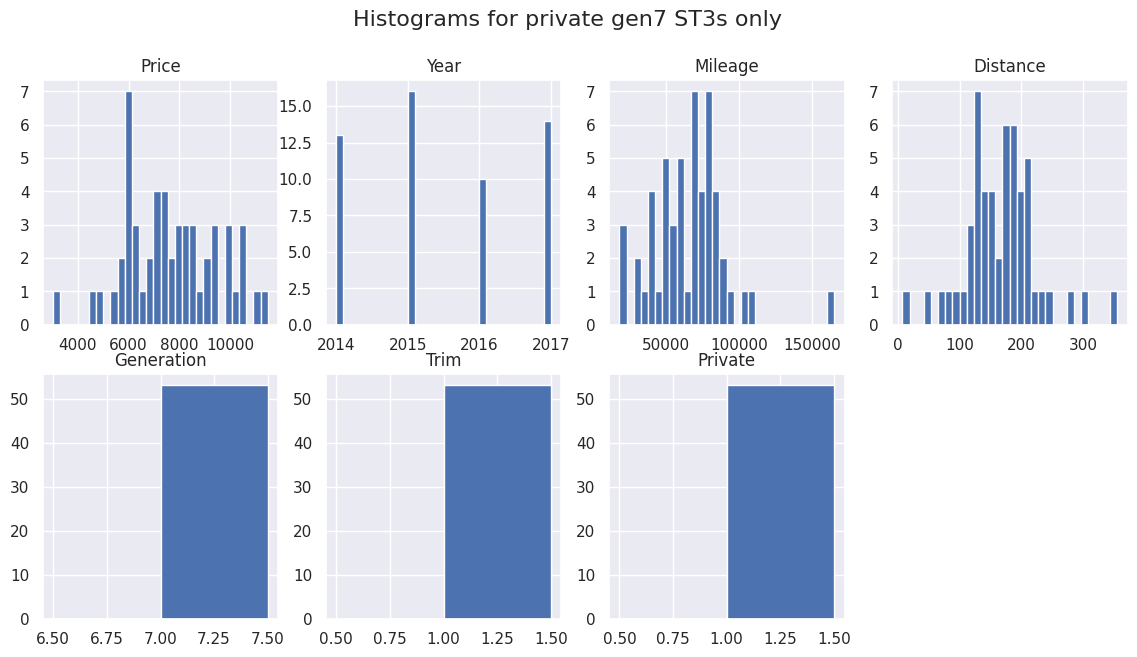

In [100]:
def histogramify(data, title):
  plt.figure(figsize=(14, 7))
  plt.suptitle(f'Histograms for {title}', fontsize=16)
  plt.subplot(2,4,1)
  plt.hist(data['Price'], bins=30)
  plt.title('Price')
  plt.subplot(2,4,2)
  plt.hist(data['Year'], bins=30)
  plt.title('Year')
  plt.subplot(2,4,3)
  plt.hist(data['Mileage'], bins=30)
  plt.title('Mileage')
  plt.subplot(2,4,4)
  plt.hist(data['Distance'], bins=30)
  plt.title('Distance')
  plt.subplot(2,4,5)
  plt.hist(data['Generation'], bins=2)
  plt.title('Generation')
  plt.subplot(2,4,6)
  plt.hist(data['Trim'], bins=2)
  plt.title('Trim')
  plt.subplot(2,4,7)
  plt.hist(data['Private'], bins=2)
  plt.title('Private')
  plt.show()

histogramify(data, 'all data')
histogramify(gen7_data, 'gen7 only')
histogramify(gen7_st3_private_data, 'private gen7 ST3s only')

# Clustering

In [101]:
data_scaled = preprocessing.scale(data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Text(0, 0.5, 'WCSS')

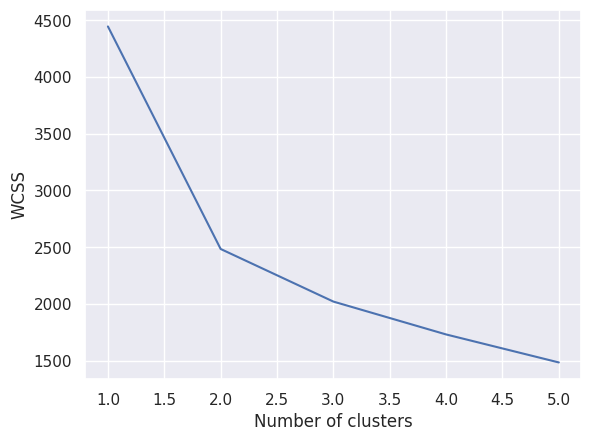

In [102]:
wcss =[]
for i in range(1,6):
    kmeans = KMeans(i)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,6),wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

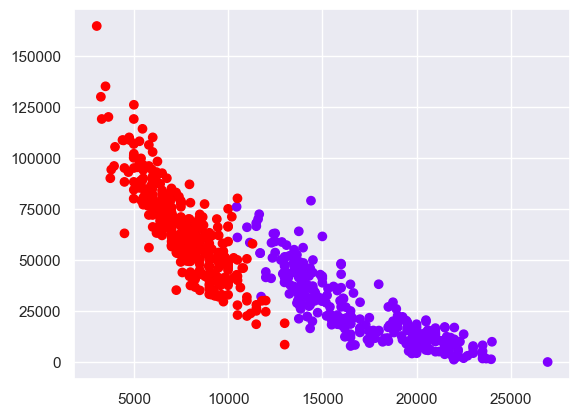

In [ ]:
kmeans = KMeans(2)
clusters = kmeans.fit_predict(data_scaled)
plt.scatter(data['Price'], data['Mileage'], c=clusters, cmap='rainbow')

# Correlations

### Variance inflation factors

In [104]:
def calculate_vif(variables, dataset_name):
    vif_data = pd.DataFrame()
    vif_data["features"] = variables.columns
    vif_data["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
    return vif_data, dataset_name

vif_sets = []

variables = data[['Year', 'Generation', 'Trim', 'Mileage', 'Distance', 'Private']]
vif_sets.append(calculate_vif(variables, 'All data'))

variables = data[['Generation', 'Trim', 'Mileage', 'Distance', 'Private']]
vif_sets.append(calculate_vif(variables, 'All data'))

variables = data[['Year', 'Trim', 'Mileage', 'Distance', 'Private']]
vif_sets.append(calculate_vif(variables, 'All data'))

variables = gen7_data[['Year', 'Trim', 'Mileage', 'Distance', 'Private']]
vif_sets.append(calculate_vif(variables, 'Gen7 only'))

variables = gen7_data[['Trim', 'Mileage', 'Distance', 'Private']]
vif_sets.append(calculate_vif(variables, 'Gen7 only'))

vif_dict = {}
for i, (vif_set, dataset_name) in enumerate(vif_sets, start=1):
    vif_dict[f'{i}: {dataset_name}'] = vif_set.set_index('features')['VIF']

combined_vif = pd.DataFrame(vif_dict)

mean_vif = combined_vif.mean().rename('Mean VIF')
combined_vif = pd.concat([combined_vif, mean_vif.to_frame().T])

desired_order = ['Year', 'Generation', 'Trim', 'Mileage', 'Distance', 'Private', 'Mean VIF']
combined_vif = combined_vif.reindex(desired_order)

combined_vif = combined_vif.round(2)

combined_vif

,1: All data,2: All data,3: All data,4: Gen7 only,5: Gen7 only
Year,523.21,NaN,12.79,16.83,NaN
Generation,445.18,10.88,NaN,NaN,NaN
Trim,2.58,2.58,2.57,1.88,1.75
Mileage,7.83,3.99,4.61,9.99,4.92
Distance,7.02,6.92,7.02,7.07,4.72
Private,1.40,1.39,1.39,1.48,1.47
Mean VIF,164.54,5.15,5.68,7.45,3.22


## Pearson correlations

In [128]:
def pearson_correlation(dataset, columns, title):
  correlation_matrix = pd.DataFrame(index=columns, columns=columns)
  highs = []

  for a in columns:
      for b in columns:
          c = np.corrcoef(dataset[a], dataset[b])[0, 1]
          correlation_matrix.loc[a, b] = c
          if (c >= 0.6 and c < 0.999) or c <= -0.6:
              key = f'{a} and {b}'
              flip_key = f'{b} and {a}'
              if flip_key not in [list(d.keys())[0] for d in highs]:
                  highs.append({key: c})

  def abs_mean(series):
      return series.abs().mean()
  row_means = correlation_matrix.apply(abs_mean, axis=1)
  column_means = correlation_matrix.apply(abs_mean, axis=0)

  correlation_matrix['Mean'] = row_means
  correlation_matrix.loc['Mean'] = column_means.tolist() + [np.nan]

  print(f'Pearson correlations for {title}\n(note: means use absolute values)')
  print(correlation_matrix.to_string(float_format=lambda x: f'{x:.3f}'))
  print()
  print('Values above 0.6 (excluding 1s)')
  sorted_highs = sorted(highs, key=lambda x: abs(list(x.values())[0]), reverse=True)
  for i in sorted_highs:
    for key, value in i.items():
      formatted_value = f'{value: .3f}' if value >= 0 else f'{value:.3f}'
      print(f'{formatted_value}:\t{key}')
  print()

pearson_correlation(data, data.columns[1:], 'all data excluding price')
pearson_correlation(data, data.columns[2:], 'all data excluding price and year')
pearson_correlation(gen7_st3_private_data, gen7_st3_private_data.drop(['Price', 'Generation', 'Trim', 'Private'], axis=1).columns, 'gen7 ST-3 private data')

Pearson correlations for all data excluding price
(note: means use absolute values)
             Year Generation   Trim Mileage Distance Private  Mean
Year        1.000      0.862  0.388  -0.790    0.018  -0.276 0.556
Generation  0.862      1.000  0.248  -0.689    0.011  -0.238 0.508
Trim        0.388      0.248  1.000  -0.294    0.039  -0.070 0.340
Mileage    -0.790     -0.689 -0.294   1.000   -0.019   0.277 0.512
Distance    0.018      0.011  0.039  -0.019    1.000  -0.073 0.193
Private    -0.276     -0.238 -0.070   0.277   -0.073   1.000 0.322
Mean        0.556      0.508  0.340   0.512    0.193   0.322   NaN

Values above 0.6 (excluding 1s)
 0.862:	Year and Generation
-0.790:	Year and Mileage
-0.689:	Generation and Mileage

Pearson correlations for all data excluding price and year
(note: means use absolute values)
           Generation   Trim Mileage Distance Private  Mean
Generation      1.000  0.248  -0.689    0.011  -0.238 0.437
Trim            0.248  1.000  -0.294    0.039  -0

In [ ]:
# Generate sample data
np.random.seed(0)
data = np.random.rand(10000, 2)
df = pd.DataFrame(data, columns=['A', 'B'])
a, b = data[:, 0], data[:, 1]

# Benchmark pandas
pandas_time = timeit.timeit(lambda: df['A'].corr(df['B'], method='pearson'), number=1000)
print(f"Pandas: {pandas_time} seconds")

# Benchmark numpy
numpy_time = timeit.timeit(lambda: np.corrcoef(a, b)[0, 1], number=1000)
print(f"Numpy: {numpy_time} seconds")

# Benchmark scipy
scipy_time = timeit.timeit(lambda: pearsonr(a, b)[0], number=1000)
print(f"Scipy: {scipy_time} seconds")

Pandas: 0.4741518030000407 seconds
Numpy: 0.2529547219999131 seconds
Scipy: 1.7314783870000383 seconds


# statsmodels

### Ordinary least squares

In [111]:
def ols(dataset, xs, title):
  print(title)
  y = dataset['Price']
  x1 = dataset[xs]
  x = sm.add_constant(x1)
  model_ols = sm.OLS(y,x).fit()
  print(model_ols.summary())
  print()

ols(data, ['Year','Generation','Trim','Mileage','Distance','Private'], 'All data, all columns')
ols(data, ['Generation','Trim','Mileage','Distance','Private'], 'All data, no year (high correlation)')
ols(data, ['Generation','Trim','Mileage','Private'], 'All data, no year (high correlation), no distance (insignificant)')
print()
print()
ols(gen7_st3_private_data, ['Year','Generation','Trim','Mileage','Distance','Private'], 'Gen7 ST-3 private data, all columns')
ols(gen7_st3_private_data, ['Generation','Trim','Mileage','Distance','Private'], 'Gen7 ST-3 private data, no year (high correlation)')
ols(gen7_st3_private_data, ['Generation','Trim','Mileage','Private'], 'Gen7 ST-3 private data, no year (high correlation), no distance (insignificant)')

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     2163.
Date:                Fri, 13 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:14:55   Log-Likelihood:                -5380.1
No. Observations:                 635   AIC:                         1.077e+04
Df Residuals:                     628   BIC:                         1.081e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.537e+06   7.34e+04    -20.941      0.0

# sklearn

In [ ]:
# X = data[(data['Generation'] == 7) & (data['Trim'] == 1)].copy()
# X = X.drop(['Price', 'Generation', 'Trim'], axis=1)
# y = data[(data['Generation'] == 7) & (data['Trim'] == 1)].copy()
# y = y['Price']

X = data.drop(['Price'], axis=1).copy()
y = data['Price'].copy()

## No split

In [ ]:
model_lr = LinearRegression()
model_lr.fit(X,y)
p_lr = model_lr.predict(mine).astype(int)
model_lr_summary = pd.DataFrame(X.columns.values, columns=['Features'])
model_lr_summary['Weights'] = model_lr.coef_

model_dtr = DecisionTreeRegressor()
model_dtr.fit(X,y)
p_dtr = model_dtr.predict(mine).astype(int)

model_rfr = RandomForestRegressor()
model_rfr.fit(X,y)
p_rfr = model_rfr.predict(mine).astype(int)

model_gbr = GradientBoostingRegressor(random_state=42)
model_gbr.fit(X,y)
p_gbr = model_gbr.predict(mine).astype(int)

model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X,y)
p_xgb = model_xgb.predict(mine).astype(int)

print(f'Linear:         £{p_lr[0]}')
print(f'Decision Tree:  £{p_dtr[0]}')
print(f'Random Forest:  £{p_rfr[0]}')
print(f'Gradient Boost: £{p_gbr[0]}')
print(f'XGB Boost:      £{p_xgb[0]}')
print(f'Mean:           £{int(np.mean([p_lr,p_dtr,p_rfr,p_gbr,p_xgb]))}')
print()
model_lr_summary

Linear:         £10628
Decision Tree:  £9999
Random Forest:  £9998
Gradient Boost: £10027
XGB Boost:      £10013
Mean:           £10133



,Features,Weights
0,Year,2.447860
1,Generation,4968.125551
2,Trim,1636.632518
3,Mileage,-0.097870
4,Distance,0.427192
5,Private,-696.144728


## Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
p_lr = model_lr.predict(X_test).astype(int)

model_dtr = DecisionTreeRegressor(random_state=42)
model_dtr.fit(X_train,y_train)
p_dtr = model_dtr.predict(X_test).astype(int)

model_rfr = RandomForestRegressor(random_state=42, n_estimators=100, criterion='absolute_error', max_depth=10, min_samples_split=5)
model_rfr.fit(X_train,y_train)
p_rfr = model_rfr.predict(X_test).astype(int)

model_gbr = GradientBoostingRegressor(random_state=42)
model_gbr.fit(X_train,y_train)
p_gbr = model_gbr.predict(X_test).astype(int)

model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X_train,y_train)
p_xgb = model_xgb.predict(X_test).astype(int)

mae_lr = mean_absolute_error(y_test, p_lr)
mae_dtr = mean_absolute_error(y_test, p_dtr)
mae_rfr = mean_absolute_error(y_test, p_rfr)
mae_gbr = mean_absolute_error(y_test, p_gbr)
mae_xgb = mean_absolute_error(y_test, p_xgb)

print(f'Gradient Boosting:\t{p_gbr[:5]}\t\tMAE: {int(mae_gbr)}\tPrediction: £{int(model_gbr.predict(mine)[0])}')
print(f'Random Forest:\t\t{p_rfr[:5]}\t\tMAE: {int(mae_rfr)}\tPrediction: £{int(model_rfr.predict(mine)[0])}')
print(f'XGB Boost:\t\t{p_xgb[:5]}\t\tMAE: {int(mae_xgb)}\tPrediction: £{int(model_xgb.predict(mine)[0])}')
print(f'Decision Tree:\t\t{p_dtr[:5]}\t\tMAE: {int(mae_dtr)}\tPrediction: £{int(model_dtr.predict(mine)[0])}')
print(f'Linear:\t\t\t{p_lr[:5]}\t\tMAE: {int(mae_lr)}\tPrediction: £{int(model_lr.predict(mine)[0])}')

Gradient Boosting:	[18240  8742 14788  8376  9036]		MAE: 513	Prediction: £9745
Random Forest:		[18706  8265 14975  8305  9204]		MAE: 598	Prediction: £9812
XGB Boost:		[18421  8404 14264  8241  9291]		MAE: 594	Prediction: £10052
Decision Tree:		[19995  7750 14198  7495  9395]		MAE: 846	Prediction: £9995
Linear:			[18356  9496 16178  8633  9163]		MAE: 890	Prediction: £10903


## Tuning and experimenting

### Cross validation

In [ ]:
cv = 10

model_gbr = GradientBoostingRegressor(random_state=42)
scores = cross_val_score(model_gbr, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
print(f"Gradient Boost\tCV MAE: {-scores.mean():.2f}")

model_xgb = XGBRegressor(random_state=42)
scores = cross_val_score(model_xgb, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
print(f"XGB Boost\tCV MAE: {-scores.mean():.2f}")

model_rfr = RandomForestRegressor()
scores = cross_val_score(model_rfr, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
print(f"Random Forest\tCV MAE: {-scores.mean():.2f}")

model_dtr = DecisionTreeRegressor()
scores = cross_val_score(model_dtr, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
print(f"Decision Tree\tCV MAE: {-scores.mean():.2f}")

model_lr = LinearRegression()
scores = cross_val_score(model_lr, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
print(f"Linear\t\tCV MAE: {-scores.mean():.2f}")

Gradient Boost	CV MAE: 665.25
XGB Boost	CV MAE: 747.46
Random Forest	CV MAE: 705.50
Decision Tree	CV MAE: 903.75
Linear		CV MAE: 2286.99


### Manually testing with loops

In [ ]:
results = []

for n in range(0,100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=n)

    model_lr = LinearRegression()
    model_lr.fit(X_train,y_train)
    p_lr = model_lr.predict(X_test).astype(int)
    p_lr_mine = int(model_lr.predict(mine)[0])
    mae_lr = mean_absolute_error(y_test, p_lr)
    result = {f'Linear\t\t{n}': [int(mae_lr), p_lr_mine]}
    results.append(result)

    model_dtr = DecisionTreeRegressor(random_state=n)
    model_dtr.fit(X_train,y_train)
    p_dtr = model_dtr.predict(X_test).astype(int)
    p_dtr_mine = int(model_dtr.predict(mine)[0])
    mae_dtr = mean_absolute_error(y_test, p_dtr)
    result = {f'Decision Tree\t{n}': [int(mae_dtr), p_dtr_mine]}
    results.append(result)

    model_rfr = RandomForestRegressor(random_state=n)
    model_rfr.fit(X_train,y_train)
    p_rfr = model_rfr.predict(X_test).astype(int)
    p_rfr_mine = int(model_rfr.predict(mine)[0])
    mae_rfr = mean_absolute_error(y_test, p_rfr)
    result = {f'Random Forest\t{n}': [int(mae_rfr), p_rfr_mine]}
    results.append(result)

    model_gbr = GradientBoostingRegressor(random_state=n)
    model_gbr.fit(X_train,y_train)
    p_gbr = model_gbr.predict(X_test).astype(int)
    p_gbr_mine = int(model_gbr.predict(mine)[0])
    mae_gbr = mean_absolute_error(y_test, p_gbr)
    result = {f'Gradient Boost\t{n}': [int(mae_gbr), p_gbr_mine]}
    results.append(result)

    model_xgb = XGBRegressor(random_state=n)
    model_xgb.fit(X_train,y_train)
    p_xgb = model_xgb.predict(X_test).astype(int)
    p_xgb_mine = int(model_xgb.predict(mine)[0])
    mae_xgb = mean_absolute_error(y_test, p_xgb)
    result = {f'XGB Boost\t{n}': [int(mae_xgb), p_xgb_mine]}
    results.append(result)

    # print(f'Random state: {n}')
    # print(f'Random Forest:\t\t{p_rfr[:5]}\t\tMAE: {int(mae_rfr)}\tPrediction: £{p_rfr_mine}')
    # print(f'Linear:\t\t\t{p_lr[:5]}\t\tMAE: {int(mae_lr)}\tPrediction: £{p_lr_mine}')
    # print(f'Gradient Boost:\t\t{p_gbr[:5]}\t\tMAE: {int(mae_gbr)}\tPrediction: £{p_gbr_mine}')
    # print(f'XGB Boost:\t\t{p_xgb[:5]}\t\tMAE: {int(mae_xgb)}\tPrediction: £{p_xgb_mine}')
    # print(f'Decision Tree:\t\t{p_dtr[:5]}\t\tMAE: {int(mae_dtr)}\tPrediction: £{p_dtr_mine}')
    # print()

sorted_results = sorted(results, key=lambda x: list(x.values())[0])
sorted_results
for result in sorted_results[:10]:
    model, info = list(result.items())[0]
    print(f"{model}\t{info}")

Gradient Boost	42	[500, 9587]
Gradient Boost	65	[540, 9796]
Gradient Boost	72	[544, 9873]
Random Forest	67	[556, 9999]
Gradient Boost	90	[556, 10154]
Gradient Boost	1	[557, 9492]
Gradient Boost	70	[559, 9914]
Gradient Boost	46	[564, 10099]
Random Forest	65	[568, 9816]
Random Forest	19	[570, 10090]


In [ ]:
def score_model(model, X_t=X_train, X_v=X_test, y_t=y_train, y_v=y_test):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

results = []

for est in range(50,151,50):
    for dep in range(3,6):
        for spl in range (2,5):
            model = RandomForestRegressor(random_state=42, n_estimators=est, max_depth=dep, min_samples_split=spl, criterion='absolute_error')
            mae = int(score_model(model))
            result = {f'{est}\t{dep}\t{spl}':int(mae)}
            print(f'{est}/{dep}/{spl}', end=' ')
            results.append(result)

print()
print()

sorted_results = sorted(results, key=lambda x: list(x.values())[0])
for result in sorted_results[:10]:
    model, number = list(result.items())[0]
    print(f"{model}\t{number}")

50/3/2 50/3/3 50/3/4 50/4/2 50/4/3 50/4/4 50/5/2 50/5/3 50/5/4 100/3/2 100/3/3 100/3/4 100/4/2 100/4/3 100/4/4 100/5/2 100/5/3 100/5/4 150/3/2 150/3/3 150/3/4 150/4/2 150/4/3 150/4/4 150/5/2 150/5/3 150/5/4 

150	5	2	594
150	5	3	594
100	5	2	596
50	5	2	597
100	5	3	597
150	5	4	597
50	5	3	598
50	5	4	599
100	5	4	599
100	4	3	605


### Random forest gridsearch

In [ ]:
n_estimators_range = list(range(50,201,50))
max_depth_range = list(range(1,21))
min_samples_split_range = list(range(2,22))
param_grid = {
    'n_estimators': n_estimators_range,
    'max_depth': max_depth_range,
    'min_samples_split': min_samples_split_range,
    'criterion': ['squared_error', 'absolute_error']
}

params = { 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 10, 'criterion': 'squared_error' }
model_rf = RandomForestRegressor(random_state=53, **params)
start_time = time.time()
for i in range(10):
    model_rf.fit(X_train, y_train)
end_time = time.time()
sample_fit_time = end_time - start_time
print(f"Time taken for 10 fits: {sample_fit_time:.4f} seconds")

cv = 5
fits = len(n_estimators_range) * len(max_depth_range) * len(min_samples_split_range) * len(param_grid['criterion']) * cv * 3
print(f"Total number of fits: {fits}")
print(f"Approximate time for all fits: {sample_fit_time/10*fits/60:.2f} minutes")

Time taken for 10 fits: 1.0440 seconds
Total number of fits: 48000
Approximate time for all fits: 83.52 minutes


In [ ]:
model_rf = RandomForestRegressor(random_state=53)

grid_search_rf_mae = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=cv, scoring='neg_mean_absolute_error', error_score='raise')
grid_search_rf_mae.fit(X_train, y_train)
print(f'grid_search_rf_mae complete')

grid_search_rf_mse = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
grid_search_rf_mse.fit(X_train, y_train)
print(f'grid_search_rf_mse complete')

grid_search_rf_r2 = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=cv, scoring='r2', error_score='raise')
grid_search_rf_r2.fit(X_train, y_train)
print(f'grid_search_rf_r2 complete')
print()

print(f"Best Parameters (MAE): {grid_search_rf_mae.best_params_}")
print(f"Best Parameters (MSE): {grid_search_rf_mse.best_params_}")
print(f"Best Parameters (R²): {grid_search_rf_r2.best_params_}")
print()
print(f"Best Score (MAE): {-grid_search_rf_mae.best_score_:.2f}")
print(f"Best Score (MSE): {-grid_search_rf_mse.best_score_:.2f}")
print(f"Best Score (R²): {grid_search_rf_r2.best_score_:.2f}")

C:\Users\jgibb\.pyenv\pyenv-win\versions\3.12.5\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


grid_search_mae complete
grid_search_mse complete
grid_search_r2 complete

Best Parameters (MAE): {'criterion': 'absolute_error', 'max_depth': 9, 'min_samples_split': 7, 'n_estimators': 200}
Best Parameters (MSE): {'criterion': 'absolute_error', 'max_depth': 13, 'min_samples_split': 5, 'n_estimators': 50}
Best Parameters (R2): {'criterion': 'absolute_error', 'max_depth': 9, 'min_samples_split': 7, 'n_estimators': 50}

Best Score (MAE): 763.63
Best Score (MSE): 1033037.40
Best Score (R2): 0.97


C:\Users\jgibb\.pyenv\pyenv-win\versions\3.12.5\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### Gradient boosting gridsearch

In [ ]:
learning_rate_range = np.arange(0.1, 0.6, 0.1)
learning_rate_range = np.round(learning_rate_range, decimals=1)
learning_rate_range = learning_rate_range.tolist()
n_estimators_range = list(range(100,301,50))
max_depth_range = list(range(1,11))
param_grid = {
    'learning_rate': learning_rate_range,
    'n_estimators': n_estimators_range,
    'max_depth': max_depth_range,
    'criterion': ['squared_error', 'friedman_mse']
}

params = { 'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'criterion': 'friedman_mse' }
model_gb = GradientBoostingRegressor(random_state=42, **params)
start_time = time.time()
for i in range(10):
    model_gb.fit(X_train, y_train)
end_time = time.time()
single_fit_time = end_time - start_time
print(f"Time taken for 10 fits: {sample_fit_time:.4f} seconds")

cv = 5
fits = len(n_estimators_range) * len(max_depth_range) * len(min_samples_split_range) * len(param_grid['criterion']) * cv * 3
print(f"Total number of fits: {fits}")
print(f"Approximate time for all fits: {sample_fit_time/10*fits/60:.2f} minutes")

Time taken for 10 fits: 0.7127 seconds
Total number of fits: 30000
Approximate time for all fits: 35.64 minutes


In [ ]:
model_gb = GradientBoostingRegressor(random_state=20)

grid_search_gb_mae = GridSearchCV(estimator=model_gb, param_grid=param_grid, cv=cv, scoring='neg_mean_absolute_error', error_score='raise')
grid_search_gb_mae.fit(X_train, y_train)
print(f'grid_search_gb_mae complete')

grid_search_gb_mse = GridSearchCV(estimator=model_gb, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
grid_search_gb_mse.fit(X_train, y_train)
print(f'grid_search_gb_mse complete')

grid_search_gb_r2 = GridSearchCV(estimator=model_gb, param_grid=param_grid, cv=cv, scoring='r2', error_score='raise')
grid_search_gb_r2.fit(X_train, y_train)
print(f'grid_search_gb_r2 complete')
print()

print(f"Best Parameters (MAE): {grid_search_gb_mae.best_params_}")
print(f"Best Parameters (MSE): {grid_search_gb_mse.best_params_}")
print(f"Best Parameters (R²): {grid_search_gb_r2.best_params_}")
print()
print(f"Best Score (MAE): {-grid_search_gb_mae.best_score_:.2f}")
print(f"Best Score (MSE): {-grid_search_gb_mse.best_score_:.2f}")
print(f"Best Score (R²): {grid_search_gb_r2.best_score_:.2f}")

grid_search_gb_mae complete
grid_search_gb_mse complete
grid_search_gb_r2 complete

Best Parameters (MAE): {'criterion': 'squared_error', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Parameters (MSE): {'criterion': 'squared_error', 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
Best Parameters (R2): {'criterion': 'squared_error', 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}

Best Score (MAE): 668.19
Best Score (MSE): 812269.27
Best Score (R2): 0.97


### Linear vs random forest vs gradient boosting

In [ ]:
# params_rf = {
#     'min_samples_split': grid_search_rf_mae.best_params_['min_samples_split'],
#     'n_estimators': grid_search_rf_mae.best_params_['n_estimators'],
#     'max_depth': grid_search_rf_mae.best_params_['max_depth'],
#     'criterion': grid_search_rf_mae.best_params_['criterion']
# }
params_rf = {
    'min_samples_split': 5,
    'n_estimators': 200,
    'max_depth': 10,
    'criterion': 'absolute_error'
}
rs_rf=53

# params_gb = {
#     'learning_rate': grid_search_gb_mae.best_params_['learning_rate'],
#     'n_estimators': grid_search_gb_mae.best_params_['n_estimators'],
#     'max_depth': grid_search_gb_mae.best_params_['max_depth'],
#     'criterion': grid_search_gb_mae.best_params_['criterion'],
# }
params_gb = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 3,
    'criterion': 'squared_error',
}
rs_gb=42

model_lr = LinearRegression()
model_rf = RandomForestRegressor(random_state=rs_rf, **params_rf)
model_gb = GradientBoostingRegressor(random_state=rs_gb, **params_gb)

scoring = make_scorer(mean_absolute_error)

cv_scores_lr = cross_val_score(model_lr, X, y, cv=5, scoring=scoring)
mean_mae_lr = cv_scores_lr.mean()
std_mae_lr = cv_scores_lr.std()
cv_scores_rf = cross_val_score(model_rf, X, y, cv=5, scoring=scoring)
mean_mae_rf = cv_scores_rf.mean()
std_mae_rf = cv_scores_rf.std()
cv_scores_gb = cross_val_score(model_gb, X, y, cv=5, scoring=scoring)
mean_mae_gb = cv_scores_gb.mean()
std_mae_gb = cv_scores_gb.std()

model_lr.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_gb.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)
y_pred_rf = model_rf.predict(X_test)
y_pred_gb = model_gb.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Linear\t\t\tMean MAE:\t{mean_mae_lr:.2f}")
print(f"Random Forest\t\tMean MAE:\t{mean_mae_rf:.2f}")
print(f"Gradient Boosting\tMean MAE:\t{mean_mae_gb:.2f}")
print()
print(f"Linear\t\t\tStd MAE:\t{std_mae_lr:.2f}")
print(f"Random Forest\t\tStd MAE:\t{std_mae_rf:.2f}")
print(f"Gradient Boosting\tStd MAE:\t{std_mae_gb:.2f}")
print()
print(f"Linear\t\t\tMSE:\t{mse_lr:.2f}")
print(f"Random Forest\t\tMSE:\t{mse_rf:.2f}")
print(f"Gradient Boosting\tMSE:\t{mse_gb:.2f}")
print()
print(f"Linear\t\t\tR²:\t{r2_lr:.2f}")
print(f"Random Forest\t\tR²:\t{r2_rf:.2f}")
print(f"Gradient Boosting\tR²:\t{r2_gb:.2f}")
print()

Linear			Mean MAE:	2673.91
Random Forest		Mean MAE:	2012.45
Gradient Boosting	Mean MAE:	1805.50

Linear			Std MAE:	1816.25
Random Forest		Std MAE:	998.14
Gradient Boosting	Std MAE:	773.84

Linear			MSE:	2519242.71
Random Forest		MSE:	751407.01
Gradient Boosting	MSE:	712873.71

Linear			R²:	0.93
Random Forest		R²:	0.98
Gradient Boosting	R²:	0.98



In [ ]:
def compare(model):
    print(model)
    cv_scores = cross_val_score(model, X, y, cv=5, scoring=scoring)
    mean_mae = cv_scores.mean()
    std_mae = cv_scores.std()
    print(f"Mean MAE:\t{mean_mae:.2f}")
    print(f"Std MAE:\t{std_mae:.2f}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MSE:\t\t{mse:.2f}")
    print(f"R²:\t\t{r2:.2f}")
    print()

compare(model_lr)
compare(model_rf)
compare(model_gb)

LinearRegression()
Mean MAE:	2673.91
Std MAE:	1816.25
MSE:		2519242.71
R²:		0.93

RandomForestRegressor(criterion='absolute_error', max_depth=10,
                      min_samples_split=5, n_estimators=200, random_state=53)
Mean MAE:	2012.45
Std MAE:	998.14
MSE:		751407.01
R²:		0.98

GradientBoostingRegressor(criterion='squared_error', random_state=42)
Mean MAE:	1805.50
Std MAE:	773.84
MSE:		712873.71
R²:		0.98



In [ ]:
t_stat, p_value = ttest_rel(cv_scores_lr, cv_scores_gb)

print(f"Paired t-test (lr, gb) - t-statistic:\t{t_stat:.2f}")
print(f"Paired t-test (lr, gb) - p-value:\t{p_value:.2f}")

Paired t-test (lr, gb) - t-statistic:	0.96
Paired t-test (lr, gb) - p-value:	0.39


In [ ]:
int(model_gb.predict(mine)[0])

9878